In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.typing import NDArray
from python_utils.signal_utils.signal_1d import Signal

EMG pre-processing
- Scaling
    - Clamp data to +/- 5 mV, which is the typical range for EMG samples ([source](https://www.sciencedirect.com/science/article/pii/S1388245719311782)).
    - Normalize data to +/- 1 mV
- EMG-LE processing (method derived from this [paper](https://www.nature.com/articles/s41598-023-33319-4))
    - FFC filter @ 60 Hz
    - Full-wave rectification
    - Moving average @ 5 Hz (N=88 samples @ 1 kHz)
      - $ f_c \approx \frac{1}{2 \pi N T} $
    
      - $ f_c \approx \frac{0.443}{N T} @ f_c = -3 dB$

      - $ N \approx \frac{0.443}{N T} $

      - $ N \approx \frac{0.443}{5(0.001)} $
      
      - $ N \approx 88 $
- Clamp data to (0,1)

Additional steps for specific use-case
- Average data across EMG channels into unified signal

In [2]:
emg_data: NDArray = np.load("raw_emg_data.npy", allow_pickle=True)

In [3]:
emg_data.shape

(34, 10, 6)

In [4]:
# Filter the data
rescaled_data = np.zeros(emg_data.shape, dtype=object)
for i in range(emg_data.shape[0]):
    for j in range(emg_data.shape[1]):
        for k in range(emg_data.shape[2]):
            rescaled_data[i][j][k] = Signal(
                emg_data[i][j][k]
            ).clamp(
                -5.0, 
                5.0
            ).map(
                -5.0, 
                5.0, 
                -1.0, 
                1.0
            ).as_numpy()

In [5]:
# Filter the data
filtered_data = np.zeros(emg_data.shape, dtype=object)
for i in range(emg_data.shape[0]):
    for j in range(emg_data.shape[1]):
        for k in range(emg_data.shape[2]):
            filtered_data[i][j][k] = Signal(
                rescaled_data[i][j][k]
            ).compute_ffc( # FFC @ 60 Hz
                f = 60.0/1000.0
            ).as_absolute(
                # full-wave rectification
            ).compute_moving_average(
                N = 88 # 5 Hz
            ).clamp(
                # Ensure all data points are between 0-1
                0.0, 
                1.0
            ).as_numpy()

KeyboardInterrupt: 

In [6]:
filtered_data.shape

(34, 10, 6)

In [7]:
# Average across channels
filtered_data_unified = np.average(filtered_data, axis=2)
filtered_data_unified.shape

(34, 10)

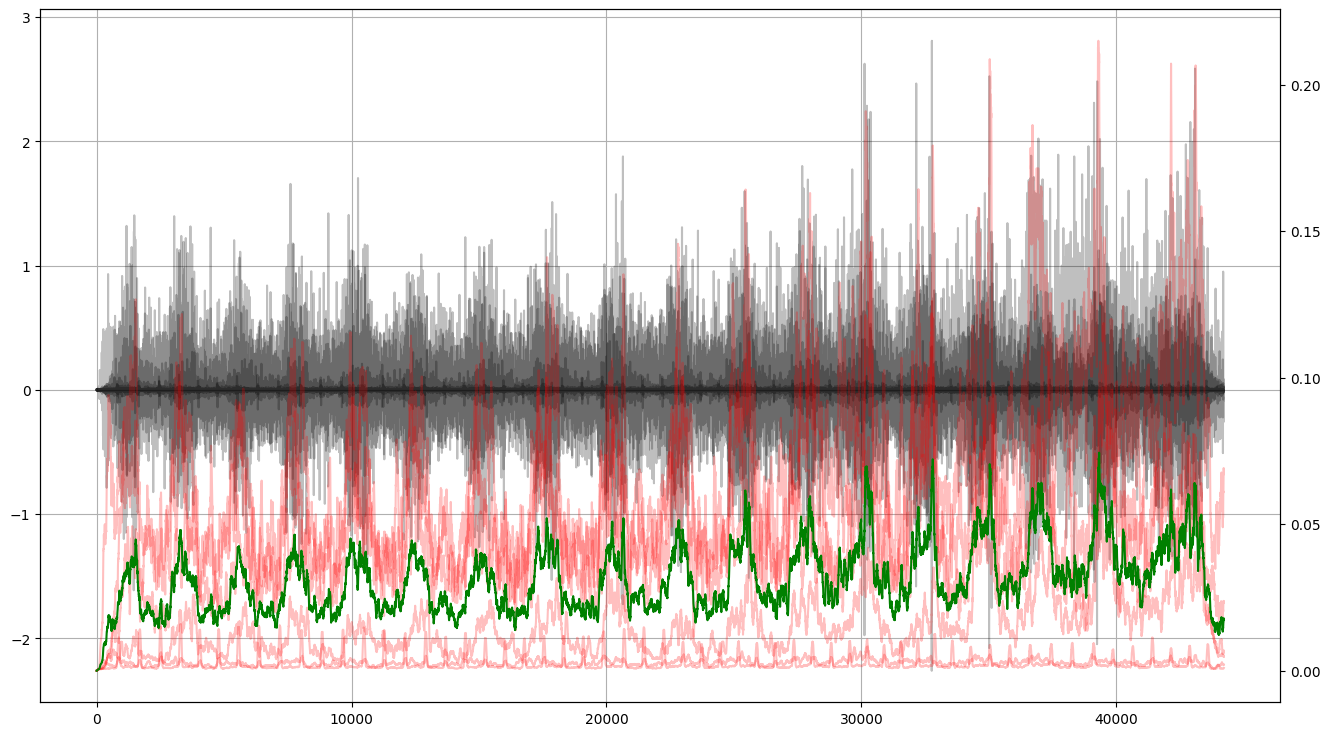

In [21]:
subject = 8
experiment = 4

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax2 = ax.twinx()

for i,emg in enumerate(emg_data[subject][experiment]):
    ax.plot(emg, alpha = 0.25, color = 'k')

for channel in filtered_data[subject][experiment]:
    ax2.plot(channel, alpha = 0.25, color = 'r')

ax2.plot(filtered_data_unified[subject][experiment], color = 'g')

ax.grid()
ax.set_axisbelow(True)

Label pre-processing

- Append final fatigue value to labels
- Generate time vector corresponding to 
- Pchirp interpolation with upsample factor of 1000x
    - 1000x factor chosen to match sampling rate of the EMG data
- Map the values from 6-20 to 0-1

In [9]:
labels: NDArray = np.load("fatigue_borg_labels.npy", allow_pickle=True)

In [10]:
time_series_labels = np.zeros((labels.shape[0], labels.shape[1], (labels.shape[2]-2)*10000), dtype=object)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        for k in range(labels.shape[2]-2):
            for l in range(10000):
                time_series_labels[i][j][k*10000+l] = labels[i][j][k]

In [11]:
cubic_spline_labels = np.zeros((labels.shape[0], labels.shape[1]), dtype=object)
for i in range(labels.shape[0]):
    for j in range(labels.shape[1]):
        x = labels[i][j]
        no_na_x = x[~np.isnan(x.astype(np.float64))]
        cubic_spline_labels[i][j] = Signal(
            data = no_na_x[:-1],
            t = np.array(np.arange(0, (no_na_x.size-2)*10, 10).tolist() + [no_na_x[-1]])
        ).pchip_interp(
            upsample_factor = 1000
        ).map(
            6.0,
            20.0,
            0.0,
            1.0    
        ).as_numpy()

94000.0 1.0


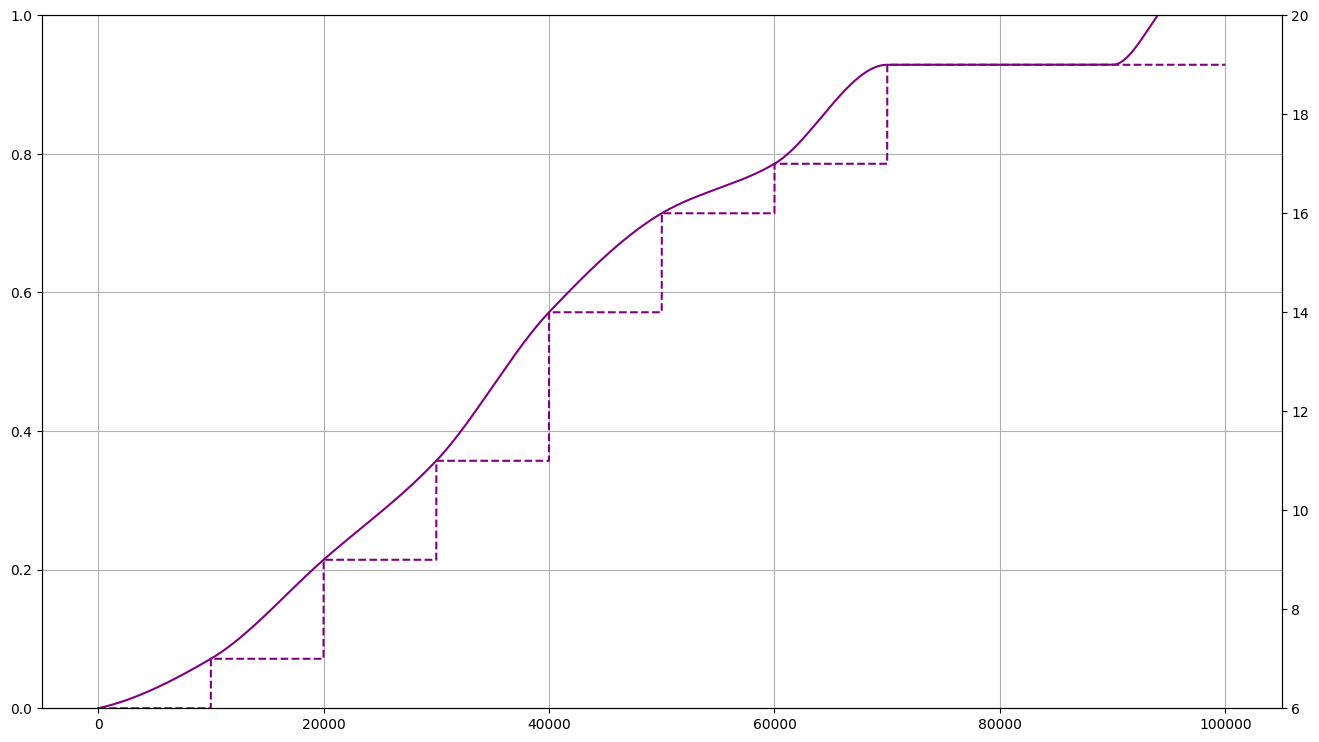

In [20]:
subject = 4
experiment = 3

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
# ax2 = ax.twinx()
# ax3 = ax.twinx()
# ax3 = ax2
ax4 = ax.twinx()
# for i,emg in enumerate(emg_data[subject][experiment]):
#     ax.plot(emg, alpha = 0.25, color = 'k')

# for channel in rescaled_data[subject][experiment]:
#     ax2.plot(channel, alpha = 0.25, color = 'r')

# for channel in filtered_data[subject][experiment]:
#     ax3.plot(channel, alpha = 0.25, color = 'r')

# ax3.plot(np.average(filtered_data[subject][experiment], axis = 0), color = 'g')

ax.plot(
    np.linspace(
        0, 
        cubic_spline_labels[subject][experiment].size, 
        cubic_spline_labels[subject][experiment].size, 
        endpoint=True
    ), cubic_spline_labels[subject][experiment], color = "purple")

Signal(time_series_labels[subject][experiment]).plot_signal(ax4, color = "purple", linestyle="--")

ax.set_ylim([0, 1])
ax4.set_ylim([6, 20])
ax.grid()
ax.set_axisbelow(True)

print(np.linspace(
        0, 
        cubic_spline_labels[subject][experiment].size, 
        cubic_spline_labels[subject][experiment].size, 
        endpoint=True
    )[-1],cubic_spline_labels[subject][experiment][-1])

In [13]:
import pdb; pdb.set_trace()

--Call--
> /home/gkouretas/.local/lib/python3.10/site-packages/IPython/core/displayhook.py(258)__call__()
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 



PPG pre-processing

- FFC
- Moving average @ 5 Hz (N=88 samples @ 200 Hz)
    - $ f_c \approx \frac{1}{2 \pi N T} $

    - $ f_c \approx \frac{0.443}{N T} @ f_c = -3 dB$

    - $ N \approx \frac{0.443}{N T} $

    - $ N \approx \frac{0.443}{5(0.005)} $
    
    - $ N \approx 17 $


In [13]:
ppg_data = np.load("raw_ppg_data.npy", allow_pickle=True)

In [14]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ppg_sample = Signal(ppg_data[4][5])
ppg_sample.plot_signal(ax)

# ppg_sample.compute_ffc(f = 60.0/200.0).plot_signal(ax2, color = "green", alpha = 0.5)
ppg_sample.compute_ffc(f = 60.0/200.0).compute_moving_average(N = 17).plot_signal(ax2, color = "green")

In [41]:
from typing import Callable
def compute_bpm(signal: Signal, window_size: int, min_peaks_for_initial_estimate: int = 2, height: Callable[[NDArray], float] = lambda _: None, **kwargs) -> tuple[NDArray, NDArray, NDArray]:
    _bpm = []
    _amp_peaks = []
    _t_peaks = []

    initial_bpm_found = False
                
    for i in range(0, signal.N):
        if i == 0: continue

        start_index = max(0, i-window_size)
        sliced = signal.slice_samples(start_index, i)
        sliced.compute_peaks(height = height(sliced._signal), **kwargs)

        # [1 / samples] * [200 samples / 1 sec] * [60 sec / 1 min]
        
        if not initial_bpm_found:
            if len(sliced._peaks) >= min_peaks_for_initial_estimate:
                _rate = 1/np.average(np.diff(sliced._peaks))*200*60
                for _ in range(i):
                    _bpm.append(_rate)
                initial_bpm_found = True
        elif len(sliced._peaks) >= 2:
            _rate = 1/np.average(np.diff(sliced._peaks))*200*60
            _bpm.append(_rate)
        else:
            _bpm.append(_bpm[-1])
        for t_peak, amp_peak in zip(sliced._peaks, sliced.get_peak_amplitudes()):
            _t_peaks.append(t_peak + start_index)
            _amp_peaks.append(amp_peak)

    return np.array(_bpm), np.array(_amp_peaks), np.array(_t_peaks)

In [50]:
%matplotlib inline
# signal = ppg_sample.compute_notch(f = 0.05/200.0, quality = 50.0)
WINDOW_TIME_SEC = 5
MIN_PEAKS_FOR_INITIAL_ESTIMATE = 5
f = 200
WINDOW_SIZE = int(f * WINDOW_TIME_SEC)
bpm = np.zeros(ppg_data.shape, dtype=object)
t_peaks = np.zeros(ppg_data.shape, dtype=object)
amp_peaks = np.zeros(ppg_data.shape, dtype=object)


for i_ in range(ppg_data.shape[0]):
    for j_ in range(ppg_data.shape[1]):
        print(i_,j_)

        signal = Signal(ppg_data[i_][j_]).compute_ffc(f = 60.0/200.0).compute_moving_average(N = 17)
        bpm[i_][j_], amp_peaks[i_][j_], t_peaks[i_][j_] = compute_bpm(signal, WINDOW_SIZE, MIN_PEAKS_FOR_INITIAL_ESTIMATE, distance = 50.0, height = lambda x: np.max(x)/2)

    # if i == 0:
    #     print(i, i+WINDOW_SIZE, WINDOW_TIME_SEC)
    # if i % 1000 == 0:
    #     fig = plt.figure()
    #     ax = fig.add_subplot(111)
    #     ax2 = ax.twinx()
    #     ppg_sample.slice_samples(i, i+WINDOW_SIZE).plot_signal(ax2, alpha = 0.25, color = "blue")
    #     sliced.plot_signal(ax, color = "blue")
    #     sliced.plot_peaks(ax, c = "red")
    #     ax.axhline(np.max(sliced._signal)/2)

0 0


/home/gkouretas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/gkouretas/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0 1
0 2
0 3
0 4
0 5
1 0
1 1
1 2
1 3
1 4
1 5
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3
4 4
4 5
5 0
5 1
5 2
5 3
5 4
5 5
6 0
6 1
6 2
6 3
6 4
6 5
7 0
7 1
7 2
7 3
7 4
7 5
8 0
8 1
8 2
8 3
8 4
8 5
9 0
9 1
9 2
9 3
9 4
9 5
10 0
10 1
10 2
10 3
10 4
10 5
11 0
11 1
11 2
11 3
11 4
11 5
12 0
12 1
12 2
12 3
12 4
12 5
13 0
13 1
13 2
13 3
13 4
13 5
14 0
14 1
14 2
14 3
14 4
14 5
15 0
15 1
15 2
15 3
15 4
15 5
16 0
16 1
16 2
16 3
16 4
16 5
17 0
17 1
17 2
17 3
17 4
17 5
18 0
18 1
18 2
18 3
18 4
18 5
19 0
19 1
19 2
19 3
19 4
19 5
20 0
20 1
20 2
20 3
20 4
20 5
21 0
21 1
21 2
21 3
21 4
21 5
22 0
22 1
22 2
22 3
22 4
22 5
23 0
23 1
23 2
23 3
23 4
23 5
24 0
24 1
24 2
24 3
24 4
24 5
25 0
25 1
25 2
25 3
25 4
25 5
26 0
26 1
26 2
26 3
26 4
26 5
27 0
27 1
27 2
27 3
27 4
27 5
28 0
28 1
28 2
28 3
28 4
28 5
29 0
29 1
29 2
29 3
29 4
29 5
30 0
30 1
30 2
30 3
30 4
30 5
31 0
31 1
31 2
31 3
31 4
31 5
32 0
32 1
32 2
32 3
32 4
32 5
33 0
33 1
33 2
33 3
33 4
33 5


In [47]:
subject = 23
experiment = 0

%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax2.set_yticklabels([])
ax3 = ax.twinx()

# ppg_sample.compute_ffc(f = 60.0/200.0).plot_signal(ax2, color = "green", alpha = 0.5)
ppg_sample = Signal(ppg_data[subject][experiment])
ppg_sample.plot_signal(ax, alpha = 0.25, color = "blue")
filtered_ppg_sample = ppg_sample.compute_ffc(f = 60.0/200.0).compute_moving_average(N = 17)
filtered_ppg_sample.plot_signal(ax2, color = "blue")
_bpm, _amp_pks, _t_pks = compute_bpm(filtered_ppg_sample, WINDOW_SIZE, MIN_PEAKS_FOR_INITIAL_ESTIMATE, distance = 50.0, height = lambda x: np.max(x) / 2)
for val in _bpm: print(val)
ax2.scatter(_t_pks, _amp_pks, c = "red")
ax3.plot(_bpm, color = "orange", alpha = 0.25)
ax3.plot(Signal(_bpm).compute_moving_average(N = 88)._signal, color = "orange")

/home/gkouretas/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/gkouretas/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999999999
124.99999999

In [51]:
bpm[subject][experiment][:10], Signal(bpm[subject][experiment]).clamp(30.0, 220.0).map(30.0, 220.0, 0.0, 1.0).compute_moving_average(N = 88).as_numpy()[:10]

(array([125., 125., 125., 125., 125., 125., 125., 125., 125., 125.]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

In [52]:
import copy
bpm_filtered = copy.deepcopy(bpm)
for i in range(bpm_filtered.shape[0]):
    for j in range(bpm_filtered.shape[1]):
        if np.isnan(bpm[i][j]).any():
            print(f"NaN found in bpm {i},{j}")
        bpm_filtered[i][j] = Signal(bpm[i][j]).clamp(30.0, 220.0).map(30.0, 220.0, 0.0, 1.0).compute_moving_average(N = 88).as_numpy()

In [20]:
bpm_filtered.shape

(34, 6)

In [21]:
imu_data = np.load("raw_imu_data.npy", allow_pickle=True)

In [22]:
imu_data.shape

(34, 10, 6, 9)

In [23]:
filtered_imu_data = np.zeros(imu_data.shape, dtype=object)
for i in range(imu_data.shape[0]):
    for j in range(imu_data.shape[1]):
        for k in range(imu_data.shape[2]):
            for l in range(imu_data.shape[3]):
                signal = Signal(imu_data[i][j][k][l])
                if (l >= 0 and l < 3) or (l >= 3 and l < 6):
                    # Clamp accel and gyro to +/- 10 and normalize to +/- 1
                    # Accel: in m/s2, so range is +/- 9.81
                    # Gyro: in rad/s, so clamping to 10 rad/s, which equates to an approx range of +/- 573 dps
                    signal = signal.clamp(-10, 10)
                    signal = signal.map(-10, 10, -1, 1)

                # Filter signal
                signal = signal.compute_moving_average(N = 8)
                
                # Magnetometer is in a.u., so no reference for clamping/normalization
                filtered_imu_data[i][j][k][l] = signal.as_numpy()

In [24]:
compressed_data = np.zeros(tuple(list(imu_data.shape[:3]) + [5]), dtype=object)

for i in range(imu_data.shape[0]):
    for j in range(imu_data.shape[1]):
        for k in range(imu_data.shape[2]):
            compressed_data[i][j][k][0] = np.linalg.norm(filtered_imu_data[i][j][k][:3], ord=2)
            compressed_data[i][j][k][1] = np.linalg.norm(filtered_imu_data[i][j][k][3:6], ord=2)
            compressed_data[i][j][k][2:] = filtered_imu_data[i][j][k][6:9]

In [25]:
subject = 5
experiment = 5

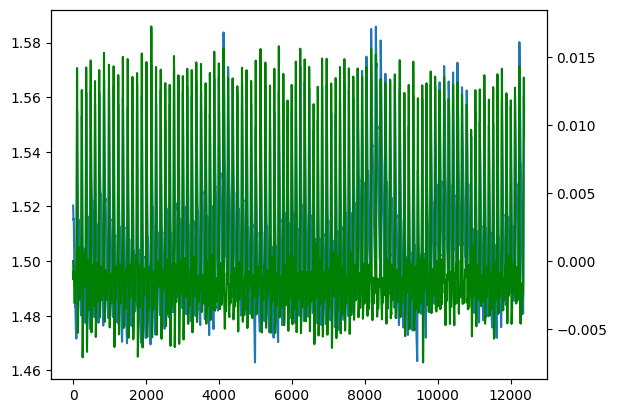

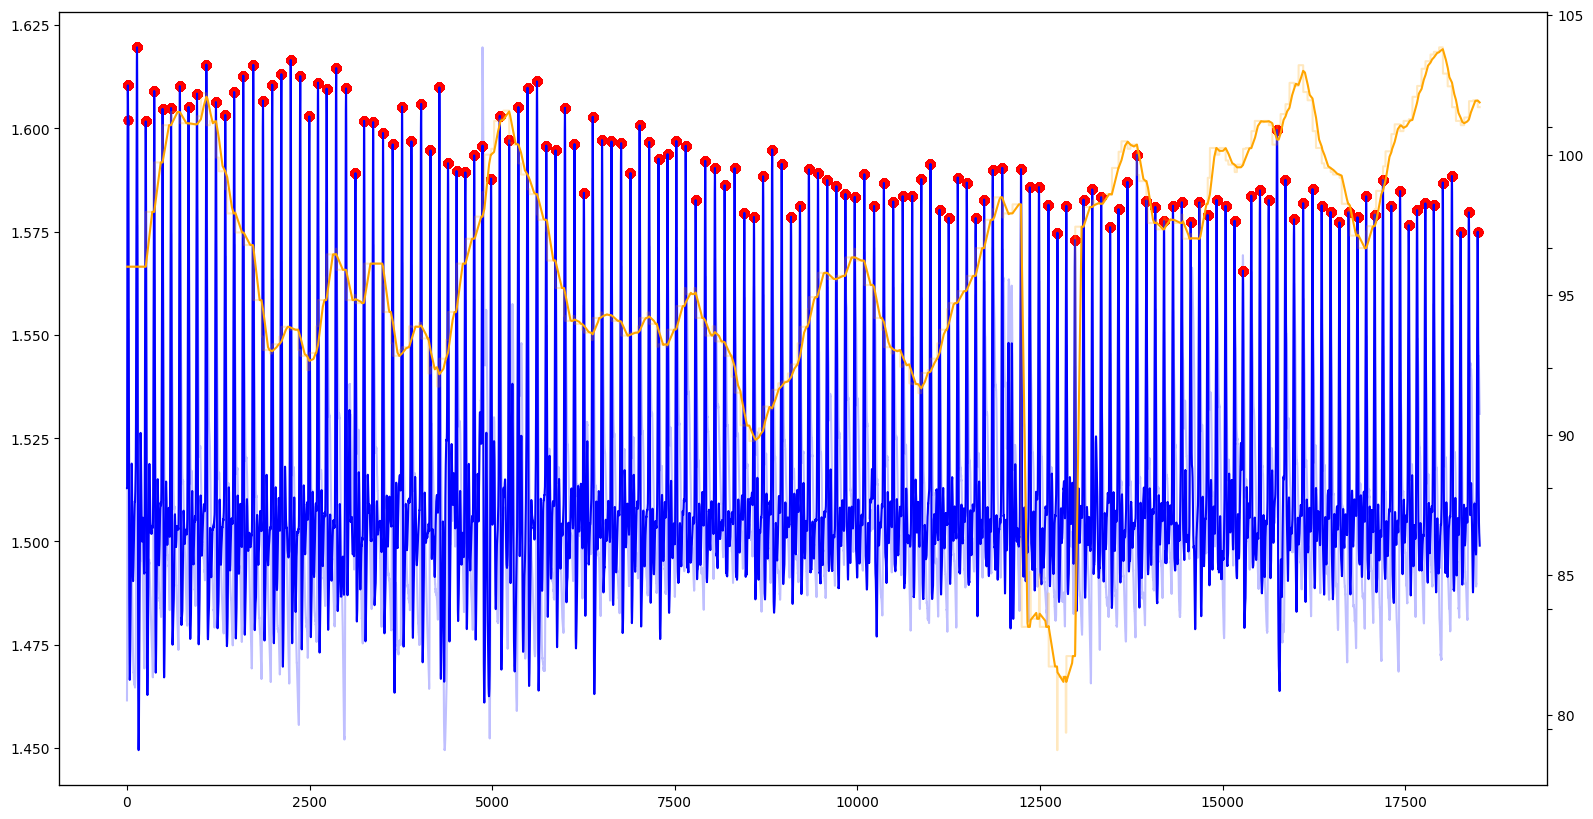

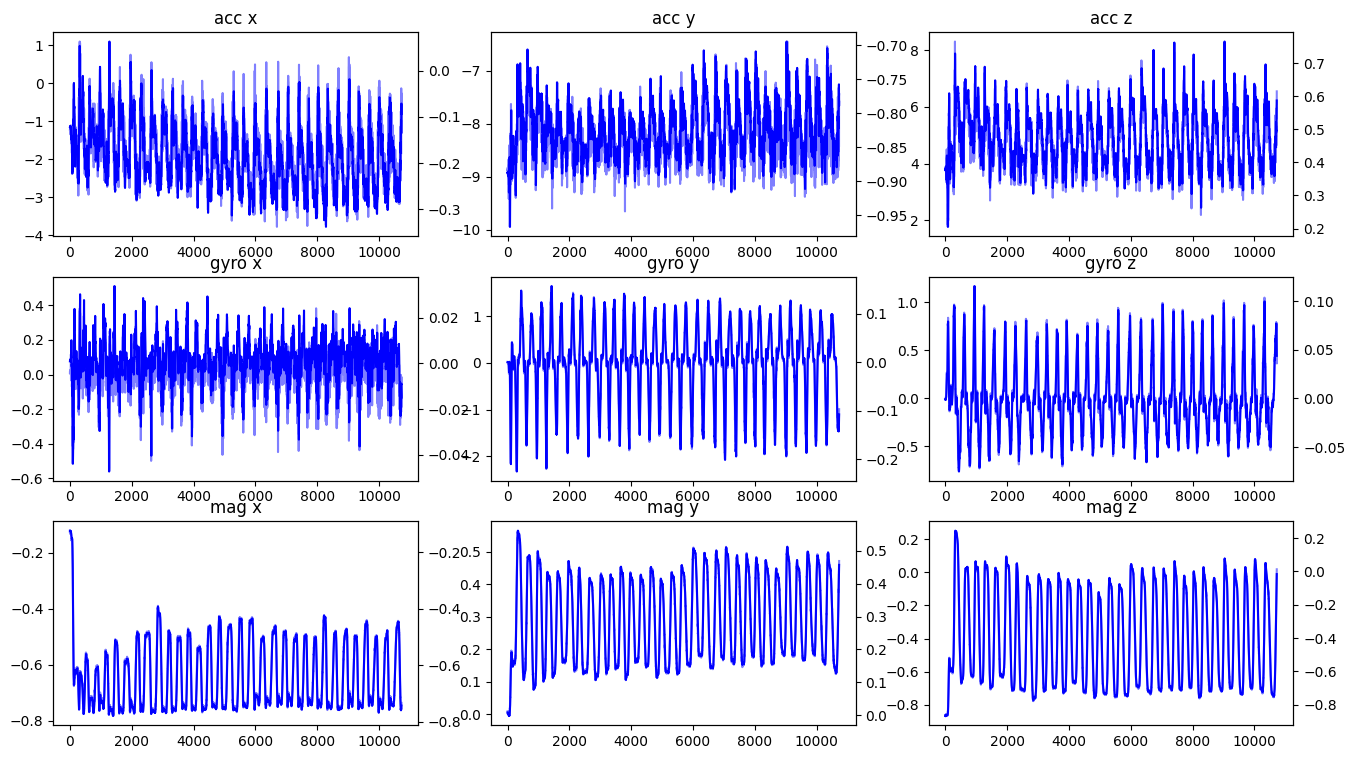

In [26]:
%matplotlib inline
fig, ax = plt.subplots(3, 3, figsize = (16,9))
titles = [
    "acc x",
    "acc y",
    "acc z",
    "gyro x",
    "gyro y",
    "gyro z",
    "mag x",
    "mag y",
    "mag z"
]

for i,a in enumerate(ax.flatten()):
    a.set_title(titles[i])
    a.plot(imu_data[subject][experiment][0][i], color = "blue", alpha = 0.5)
    ax2 = a.twinx()
    ax2.plot(filtered_imu_data[subject][experiment][0][i], color = "blue")

In [27]:
%matplotlib qt
fig, ax = plt.subplots(2, 1, figsize = (16,9), sharex=True)

ax[0].plot(compressed_data[subject][experiment][0][0])
ax[1].plot(compressed_data[subject][experiment][0][1])

In [28]:
# Remove magnetometer data
even_more_compressed_imu = compressed_data[..., :2]
even_more_compressed_imu.shape

(34, 10, 6, 2)

In [29]:
accel_norm = even_more_compressed_imu[..., 0]
for i in range(accel_norm.shape[0]):
    for j in range(accel_norm.shape[1]):
        shapes = [accel_norm[i][j][k].shape for k in range(accel_norm.shape[2])]
        if len(set(shapes)) != 1:
            min_len = min(shapes)[0]
            print(f"Reducing arrays of shapes {shapes} to length {min_len}")
            for k in range(accel_norm.shape[2]):
                accel_norm[i][j][k] = accel_norm[i][j][k][:min_len]

gyro_norm = even_more_compressed_imu[..., 1]
for i in range(gyro_norm.shape[0]):
    for j in range(gyro_norm.shape[1]):
        shapes = [gyro_norm[i][j][k].shape for k in range(gyro_norm.shape[2])]
        if len(set(shapes)) != 1:
            min_len = min(shapes)[0]
            print(f"Reducing arrays of shapes {shapes} to length {min_len}")
            for k in range(gyro_norm.shape[2]):
                gyro_norm[i][j][k] = gyro_norm[i][j][k][:min_len]

Reducing arrays of shapes [(18099,), (18099,), (18099,), (16994,), (18099,), (18099,)] to length 16994
Reducing arrays of shapes [(10639,), (10638,), (10639,), (10639,), (10639,), (10639,)] to length 10638
Reducing arrays of shapes [(6010,), (6011,), (6011,), (6011,), (6011,), (6011,)] to length 6010
Reducing arrays of shapes [(820,), (820,), (820,), (819,), (819,), (820,)] to length 819
Reducing arrays of shapes [(5673,), (5672,), (5673,), (5673,), (5673,), (5673,)] to length 5672
Reducing arrays of shapes [(9409,), (9408,), (9409,), (9409,), (9409,), (9409,)] to length 9408
Reducing arrays of shapes [(10338,), (10338,), (10338,), (10338,), (10337,), (10338,)] to length 10337
Reducing arrays of shapes [(9992,), (9992,), (9992,), (9992,), (9991,), (9992,)] to length 9991
Reducing arrays of shapes [(8553,), (8553,), (8553,), (8553,), (8553,), (8552,)] to length 8552
Reducing arrays of shapes [(5634,), (5634,), (5633,), (5634,), (5634,), (5634,)] to length 5633
Reducing arrays of shapes 

In [30]:
accel_avg = np.average(accel_norm, axis=2) - 1.0
gyro_avg = np.average(gyro_norm, axis=2)
accel_avg.shape, gyro_avg.shape

((34, 10), (34, 10))

In [31]:
imu_avg = np.stack([accel_avg, gyro_avg], axis=-1)
imu_avg.shape

(34, 10, 2)

In [40]:
%matplotlib qt
subject = 9
experiment = 5
fig, ax = plt.subplots(2, 1, figsize = (16,9), sharex=True)

ax[0].twinx().plot(imu_avg[subject][experiment][0], color = "blue")
ax[1].plot(imu_avg[subject][experiment][1], color = "blue")

ax[0].plot(compressed_data[subject][experiment][0][0], alpha = 0.25, color = "blue")
ax[1].plot(compressed_data[subject][experiment][0][1], alpha = 0.25, color = "blue")

In [33]:
filtered_data_unified.shape, bpm_filtered.shape, imu_avg.shape, cubic_spline_labels.shape

((34, 10), (34, 6), (34, 10, 2), (34, 6))

In [34]:
filtered_data_unified_with_labels = filtered_data_unified[:, :6]
imu_avg_with_labels = imu_avg[:, :6, :]

In [35]:
filtered_data_unified_with_labels.shape

(34, 6)

In [53]:
training_datasets = np.concatenate(
    [filtered_data_unified_with_labels.reshape(list(filtered_data_unified_with_labels.shape) + [1]), 
     bpm_filtered.reshape(list(bpm_filtered.shape) + [1]), 
     imu_avg_with_labels], axis=2)

In [37]:
training_datasets.shape

(34, 6, 4)

In [54]:
np.save("training_datasets.npy", training_datasets)

In [39]:
np.save("training_labels.npy", cubic_spline_labels)